# Training an Exchange Correlation Functional using Deepchem

Author : Advika Vidhyadhiraja : [Linkedin](www.linkedin.com/in/advikavidhyadhiraja) 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1MDEvTitrBreK-Pf0a_F7rNzt-8X7j97g?usp=sharing) 

In [4]:
import torch
from deepchem.utils.dft_utils.grid.lebedev_grid import LebedevGrid
from deepchem.utils.dft_utils.grid.multiatoms_grid import BeckeGrid
from deepchem.utils.dft_utils.grid.radial_grid import RadialGrid
grid = RadialGrid(100, grid_integrator="chebyshev", grid_transform="logm3")
atomgrid = [LebedevGrid(grid, 3), LebedevGrid(grid, 3)]
atompos = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]], dtype=torch.float64)
atomradii = torch.tensor([1.0, 1.0])
grid = BeckeGrid(atomgrid, atompos)
grid.get_rgrid().shape

torch.Size([1200, 3])

### Brief introduction to Density Functional Theory and Exchange Correlation Functionals

   Density-functional theory (DFT) is a theory used to calculate the electronic structure of atoms, molecules, and solids. Its objective is
to use the fundamental laws of quantum mechanics to quantitatively
comprehend the properties of materials.
    
   There are serious limitations to the tradional methods used to approximate solutions to the Schrödinger equation of N interacting electrons moving in an external potential. Whereas in DFT, instead of the many-body wave function, the density (n(r)) is a function of three spatial coordinates.
    
   The many-body electronic ground state can be described using single-particle    equations and an effective potential thanks to the Kohn-Sham theory. The exchange-correlation potential, which accounts for many-body effects, the Hartree potential, which describes the electrostatic electron-electron interaction, and the ionic potential resulting from the atomic cores make up the effective potential.
    
   The difference between the total exact energy and the total of the rest of the energy terms (such as kinetic energy), is known as the exchange-correlation energy. The exchange-correlation functional is obtained by calculating the functional derivate of the XC energy w.r.t the
electron density function. 

##### References

- Encyclopedia of Condensed Matter Physics, 2005. 

- Mark R. Pederson, Tunna Baruah, in Advances In Atomic, Molecular, and Optical Physics, 2015

- Kasim, Muhammad F., and Sam M. Vinko. "Learning the exchange-correlation functional from nature with fully differentiable density functional theory." Physical Review Letters 127.12 (2021): 126403.


### Basic Exchange Correlation Functionals 

The energy contributors in DFT can be representated as :

   $ E_{total} = E_{Kinetic} + E_{electrostatic interactions} + E_{xc}$

The first term (Kinetic energy) is calculated using a fictitious non-interacting system. The second term is the electrostatic interactions between electrons and nuclear cores. A potential energy surface is derived using the Born-Oppenheimer approximation to account for the electrostatic repulsion between the nuclear cores.

The most commonly used and simplest class of XC functionals are the Local-density approximations (LDA). The LDA assumes variations of the density to be gradual, i.e, it is  based on the homogeneous electron gas model. Which is why it is regarded as the simplest approach to the exchange correlation functional. This class of functionals depend only upon the value of the electronic density at each point in space.

The next point in the Jacob's ladder of XC functionals is the Generalized Gradient Approximation (GGA) class, which includes both the
density and its gradient.

##### References

- Voss, J. (2022) Exchange-correlation functionals, Johannes Voss. Available at: https://stanford.edu/~vossj/project/xc-functionals/ (Accessed: April 28, 2023).  

- Density-Functional Theory of the Electronic Structure of Molecules,Robert G. Parr and Weitao Yang, Annual Review of Physical Chemistry 1995 46:1,

- 701-728
R. O. Jones and O. Gunnarsson, Rev. Mod. Phys. 61, 689 (1989)

### Setup 

In [1]:
#!pip install --pre deepchem
#!pip install git+https://github.com/diffqc/dqc.git
#!pip install pylibxc2

### Datasets

There are four types of data points used to train XCModel: atomization energy (AE) calculations, ionization poten- tial (IP) calculations, density profile regulations and den- sity matrix calculations. The ground truth values for the first two types are obtained from NIST databases (Kasim & Vinko, 2021), and the rest are calculated by perform- ing CCSD calculations (using PYSCF). Users do not need to enter the equations used to calculate the total energy for AE and IP data points. We have implemented a DFTYamlLoader class in DeepChem that loads and prepares data, and featurizes the data into standard molecular

#### DFTYamlLoader and DFT data classes 

The DFTEntry data class creates and initialises DFTEntry objects from the dataset. This object contains information about the various systems in the datapoint (atoms, molecules and ions) along with the ground truth
values. A system in an entry object contains "moldesc", "basis" and "spin"
of all the atoms/molecules. These values are to be entered in the DQC or PYSCF format. The systems needs to be entered in a specific order, i.e ; the main atom/molecule needs to be the first element. (This is for objects containing equations, such as ae and ie entry objects). Spin and charge of the system are optional parameters and are considered '0' if not specified. The system number refers to the number of times the systems is present in the molecule - this is for polyatomic molecules and the
default value is 1. For example ; system number of Hydrogen in water
is 2.

In [2]:
# Example: creating a DFTEntry object 
from deepchem.feat.dft_data import DFTEntry
e_type= 'dm'
true_val= 'deepchem/data/tests/dftHF_output.npy'
systems = [{'moldesc': 'H 0.86625 0 0; F -0.86625 0 0','basis': '6-311++G(3df,3pd)'}]
dm_entry_for_HF = DFTEntry.create(e_type, true_val, systems)

#list of systems in an entry object
dm_entry_for_HF.get_systems()

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/gigavolt/deepchem/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/gigavolt/deepchem/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensor

#### Calculating ground truth values 

   For the AE and IE entry types, we use pre- calculated values from the NIST databases. For the DM and Dens datatypes, we calcute the true values using a non-DFT method called CCSD. (we use the PYSCF library to do so) 
   In this example, we will calculate the initial density matrix for Hydrogen Fluoride. 

In [3]:
# INSTALL PYSCF 
#!pip install pyscf
#import pyscf

In [4]:
# create a pyscf mol
from pyscf import gto, scf, cc
import numpy as np
import torch

mol = gto.M(atom= 'H 0.86625 0 0; F -0.86625 0 0', basis='6-311++G(3df,3pd)' ,unit="Bohr")
mf  = scf.UHF(mol).run()
mcc = cc.UCCSD(mf)
mcc.kernel()

# obtain the total density matrix
modm = mcc.make_rdm1()
aodm0 = np.dot(mf.mo_coeff[0], np.dot(modm[0], mf.mo_coeff[0].T))
aodm1 = np.dot(mf.mo_coeff[1], np.dot(modm[1], mf.mo_coeff[1].T))
aodm = aodm0 + aodm1

# save the value in a .npy file
dm = torch.as_tensor(aodm, dtype=torch.double)
outfile = "output.npy"
np.save(outfile, dm)


converged SCF energy = -100.057640174912  <S^2> = 1.4595969e-10  2S+1 = 1
E(UCCSD) = -100.3581800968686  E_corr = -0.3005399219564529


#### An example of the data type format: 

![](assets/yamldft.png) 

These values are stored in .yaml files. In case of 'dens' and 'dm', the true value will be replaced by the .npy file name containing the ccsd values.

### Featurizing and loading the dataset 

After we have built the data file, we will load it and featurize using the DFTYamlLoader class.

In [5]:
from deepchem.data.data_loader import DFTYamlLoader
#name of the yaml file
inputs = 'assets/dft_tutorial.yaml'
data = DFTYamlLoader()
dataset = data.create_dataset(inputs)


### Layers

#### NNXC layers 

The baseNNXC class can be used to build layers such as the NNLDA layer, where the exchange correlation functional is trained based on the pre-defined LDA  class of functionals. The methods in this class take the electron density as the input and transform it accordingly. For example; The NNLDA layer requires only the density to build an NNXC whereas a GGA based model would require the density gradient as well. This method also takes polarization into account.

In [6]:
# Example; using NNLDA layer 
from deepchem.models.dft.nnxc import NNLDA
import torch
import torch.nn as nn
n_input, n_hidden = 2, 1
nnmodel = (nn.Linear(n_input, n_hidden))
output = NNLDA(nnmodel)

#### HybridXC layer :

The HybridXC module computes XC energy by summing XC energy computed
from libxc(any conventional DFT functional) and the trainable neural
network with tunable weights. This layer constructs a hybrid functional based on the user's choice of what model is to be used to train the functional. This hybrid functional is a combination of the xc that is trained by a neural network, and a conventional DFT functional. It based on this equation from (Kasim & Vinko, 2021) where $\alpha$, $\beta$ are the tunable weights.
![](assets/xceqns.png)

### SCF iterations layer 


In the Kohn-Sham theory, the inclusion of the noninteracting kinetic energy functional results in a set of one-particle equations with KS
orbitals as their solutions after functional differentiation. It is a
variational approach that determines the lowest energy and the related
molecular orbitals and orbital energies by using the electron-electron
interaction potential. To learn more about Density Functional Theory
and the Kohn-Sham approach please use the references below.

The XCNNSCF is used for performing self-consistent iterations. The
XC functional in the Kohn-Sham model implementation is replaced by a
neural network.

    

In [7]:
# Example; calculating energy using the scf layer
from deepchem.models.dft.scf import XCNNSCF
import torch
from deepchem.feat.dft_data import DFTEntry, DFTSystem
from deepchem.models.dft.nnxc import HybridXC
nnmodel = (torch.nn.Sequential(torch.nn.Linear(2, 10),torch.nn.Tanh(),torch.nn.Linear(10, 1))).to(torch.double)
hybridxc = HybridXC("lda_x", nnmodel, aweight0=0.0)
evl = XCNNSCF(hybridxc, dm_entry_for_HF )
system = DFTSystem(systems[0])
run = evl.run(system)
output = run.energy()
print(output)

tensor(-99.1360, dtype=torch.float64, grad_fn=<AddBackward0>)


### Training the XC Model

The XCModel class is used to initialize and run Differentiable Quantum Chemistry (i.e, DFT) calculations, using an exchange correlation functional that has been replaced by a neural network. The model parame- ters consist of the PyTorch model used to train the functional and the choice of loss function. The forward method initializes the Neural Network LDA layer (NNXC), and hybridizes the func- tional with a traditional LDA functional. The hybrid xc is used to solve the Kohn-Sham equations. Once the self consistent iterations converge, the total energy of the data point is calculated and used to calculate the loss. The trained model can be used with DeepChem functions such as evaluate and predict with different metrics (Kasim & Vinko, 2021; Ramsundar et al., 2021a)

References 
Kasim, M. and Vinko, S. Learning the exchange-correlation functional from nature with fully differentiable density functional theory. Physical Review Letters, 127(12), sep 2021. doi: 10.1103/physrevlett.127.126403. URL https://doi.org/10.1103%2Fphysrevlett.127.126403.

Ramsundar, Peastman, Amacbride, and nvtrang91. Making
deepchem a better framework for ai-driven science, Apr
2021a. URL https://forum.deepchem.io/t/ making-deepchem-a-better-framework-for-ai-driven- 431.
Schematics of the exchange correlation XCModel.

![Schematic](assests/DFT.png)

In [8]:
dataset.y

array([0.0919441 , 0.53411947])

In [9]:
# Example: training a function using XCModel
from deepchem.models.dft.dftxc import XCModel
import deepchem as dc
import tempfile

# create a file to save the model 
model_dir = tempfile.mkdtemp()

# initialise the model 
model = XCModel("lda_x",
                    batch_size=1,
                    log_frequency=1,
                    mode="classification",
                    n_tasks=2,
                    model_dir=model_dir)

# Calculate the loss on fitting the model 
loss = model.fit(dataset, nb_epoch=1, checkpoint_interval=1)

### Predicts and evaluation using the XC model 

The predictions can be run on various different molecules. In this tutorial, we will predict energy values and plot the Hydrogen dissociation curve against CCSD values. 

Note; the predictions in this example might not be very accurate since we are only training the model on two datapoints

In [10]:
# load the datasets
import numpy as np
inputs = 'assets/h2.yaml'
data = DFTYamlLoader()
h2_dataset = data.create_dataset(inputs)
predict = model.predict(h2_dataset)



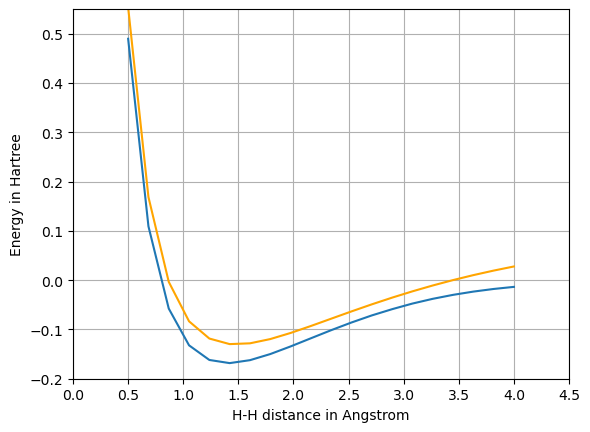

In [11]:
import matplotlib.pyplot as plt 
#plot
true_val = (h2_dataset.y) 
predict_val = (predict)*(-1)
pos = np.array([0.5000, 0.6842, 0.8684, 1.0526, 1.2368,
1.4211,
1.6053,
1.7895,
1.9737,
2.1579,
2.3421,
2.5263,
2.7105,
2.8974,
3.0789,
3.2632,
3.4474,
3.6316,
3.8158,
4.000]) 
plt.plot(pos, true_val )
plt.plot(pos, predict_val, color = 'orange')
y = pos * 0
plt.xlabel("H-H distance in Angstrom") 
plt.ylabel("Energy in Hartree")
plt.xlim([0.0, 4.5])
plt.ylim([-0.2, 0.55])
plt.grid()
plt.show()

#### Notes 

- The entry type "Density Matrix" cannot be used on model.evaluate as of now.
- To run predictions on this data type, a dataset containing only "dm" entries must be used.
- When initializing the XCModel, the user may build and pass a different pytorch model to train the XC Functional, instead of using the default method. 


## References 

- Kasim, Muhammad F., and Sam M. Vinko. "Learning the exchange-correlation
    functional from nature with fully differentiable density functional
    theory." Physical Review Letters 127.12 (2021): 126403.\
  Most of our code has been derived from the reference above. The implementation of the paper can be found in the github link below :
 https://github.com/mfkasim1/xcnn 

- Encyclopedia of Condensed Matter Physics, 2005.
- Kohn, W. and Sham, L.J., 1965. Self-consistent equations including
    exchange and correlation effects. Physical review, 140(4A), p.A1133.


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:


## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.


## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!